In [18]:
# To avoid the error while plotting "AttributeError: 'GeoAxes' object has no attribute '_autoscaleXon'"
!pip install --user matplotlib==3.5.2

In [2]:
import matplotlib
print("Matplotlib version:", matplotlib.__version__)

Matplotlib version: 3.5.2


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from nansat import Nansat, Domain, NSR

from sea_ice_drift import get_n
from sea_ice_drift.ftlib import feature_tracking
from sea_ice_drift.pmlib import pattern_matching

import csv

%matplotlib inline

In [2]:
from osgeo import gdal
from osgeo import osr

from sea_ice_drift.lib import get_spatial_mean, get_uint8_image

In [3]:
# Download arrays
f0 = gdal.Open('/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_images/HV_160/S1A_EW_GRDM_1SDH_20230212T080151_20230212T080255_047200_05A9D0_C7EB_Orb_Cal_TC_HV_160.tif')
f1 = gdal.Open('/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_images/HV_160/S1A_EW_GRDM_1SDH_20230214T074531_20230214T074635_047229_05AAC8_4014_Orb_Cal_TC_HV_160.tif')
f2 = gdal.Open('/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_forecast/HV/sar2_model/Aligned_model_full_S1A_EW_GRDM_1SDH_20230212T080151_20230212T080255_047200_05A9D0_C7EB_Orb_Cal_TC_HV_160.tif')
f3 = gdal.Open('/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_forecast/HV/sar2_alg_gpi/Aligned_alg_gpi_S1A_EW_GRDM_1SDH_20230212T080151_20230212T080255_047200_05A9D0_C7EB_Orb_Cal_TC_HV_160.tif')

In [4]:
#Set domains based on the data
n0_domen = Nansat('/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_images/HV_160/S1A_EW_GRDM_1SDH_20230212T080151_20230212T080255_047200_05A9D0_C7EB_Orb_Cal_TC_HV_160.tif')
n1_domen = Nansat('/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_images/HV_160/S1A_EW_GRDM_1SDH_20230214T074531_20230214T074635_047229_05AAC8_4014_Orb_Cal_TC_HV_160.tif')
n2_domen = Nansat('/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_forecast/HV/sar2_model/Aligned_model_full_S1A_EW_GRDM_1SDH_20230212T080151_20230212T080255_047200_05A9D0_C7EB_Orb_Cal_TC_HV_160.tif')
n3_domen = Nansat('/home/jovyan/experiment_data/2022-2023_48h_experiment/SAR_forecast/HV/sar2_alg_gpi/Aligned_alg_gpi_S1A_EW_GRDM_1SDH_20230212T080151_20230212T080255_047200_05A9D0_C7EB_Orb_Cal_TC_HV_160.tif')

In [5]:
#Load the data from the files into numpy arrays for further processing.
a0 = f0.ReadAsArray() 
a1 = f1.ReadAsArray() 
a2 = f2.ReadAsArray()
a3 = f3.ReadAsArray()

#Pre-process images to ensure consistent visualization and handle blank spots issue after pattern patching.
a0 = get_uint8_image(a0, None, None, 1, 99)
a1 = get_uint8_image(a1, None, None, 1, 99)
a2 = get_uint8_image(a2, None, None, 1, 99)
a3 = get_uint8_image(a3, None, None, 1, 99)

VMIN:  0.0
VMAX:  0.021238385755568752
VMIN:  0.0
VMAX:  0.01598892150446774
VMIN:  0.0018502648966386914
VMAX:  0.02133365400135518
VMIN:  0.0017477583931759
VMAX:  0.022014104276895523


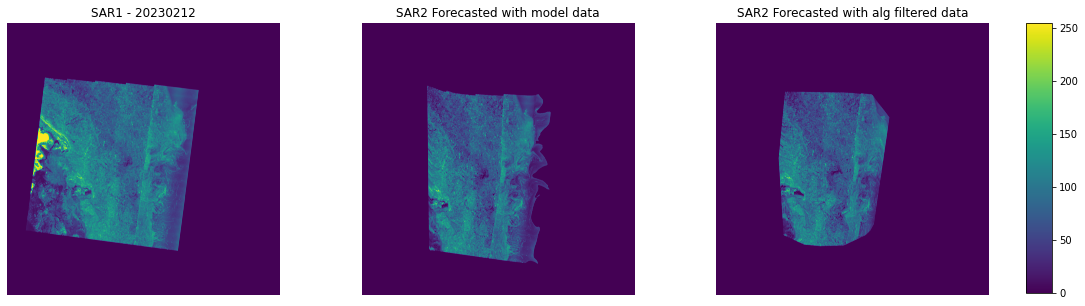

In [6]:
#Plot
fig, ax = plt.subplots(1,3, figsize=(18,5))
im1 = ax[0].imshow(a0, clim=[0, 255])
ax[0].axis('off')
#plt.colorbar(im0, ax=ax[0])
im2 = ax[1].imshow(a2, clim=[0, 255])
ax[1].axis('off')
#plt.colorbar(im1, ax=ax[1])
im3 = ax[2].imshow(a3, clim=[0, 255])
ax[2].axis('off')
cax = fig.add_axes([0.92, 0.13, 0.02, 0.75])  # Position and size of the colorbar
cbar = fig.colorbar(im3, cax=cax)
#plt.colorbar(im3, ax=ax[2])

ax[0].set_title("SAR1 - 20230212")
ax[1].set_title("SAR2 Forecasted with model data")
ax[2].set_title("SAR2 Forecasted with alg filtered data")
plt.show()

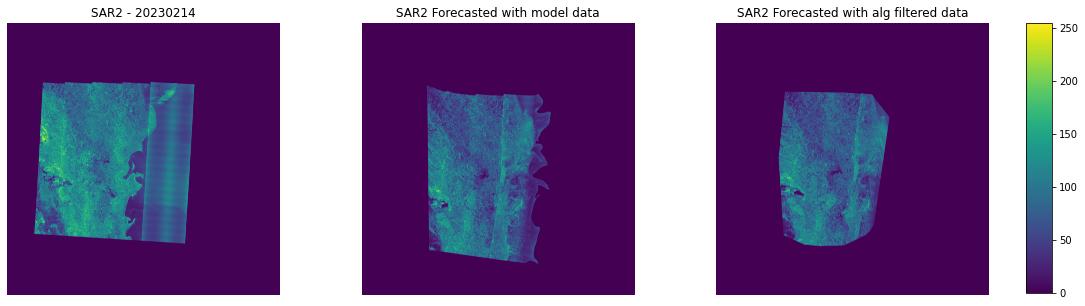

In [7]:
#Plot
fig, ax = plt.subplots(1,3, figsize=(18,5))
im1 = ax[0].imshow(a1, clim=[0, 255])
ax[0].axis('off')
#plt.colorbar(im0, ax=ax[0])
im2 = ax[1].imshow(a2, clim=[0, 255])
ax[1].axis('off')
#plt.colorbar(im1, ax=ax[1])
im3 = ax[2].imshow(a3, clim=[0, 255])
ax[2].axis('off')
cax = fig.add_axes([0.92, 0.13, 0.02, 0.75])  # Position and size of the colorbar
cbar = fig.colorbar(im3, cax=cax)
#plt.colorbar(im3, ax=ax[2])

ax[0].set_title("SAR2 - 20230214")
ax[1].set_title("SAR2 Forecasted with model data")
ax[2].set_title("SAR2 Forecasted with alg filtered data")
plt.show()

In [8]:
# Create three Nansat objects with original tiff domains imported from gdal object.

n0 = Nansat.from_domain(n0_domen, a0)
n1 = Nansat.from_domain(n1_domen, a1)
n2 = Nansat.from_domain(n2_domen, a2)
n3 = Nansat.from_domain(n3_domen, a3)

In [9]:
# Close the dataset
f0 = None
f1 = None
f2 = None
f3 = None

In [10]:
# Run Feature Tracking
# get start/end coordinates in the image coordinate system (colums/rows)  
c1, r1, c2, r2 = feature_tracking(n1, n3, nFeatures=50000, ratio_test=0.6, max_drift=100000, verbose=True)

Key points found: 50000
Key points found: 50000
Domain filter: 50000 -> 50000
Domain filter: 50000 -> 50000
Keypoints matched 4.908853769302368
Ratio test 0.600000 found 794 keypoints
MaxDrift filter: 794 -> 793
LSTSQ filter: 793 -> 792


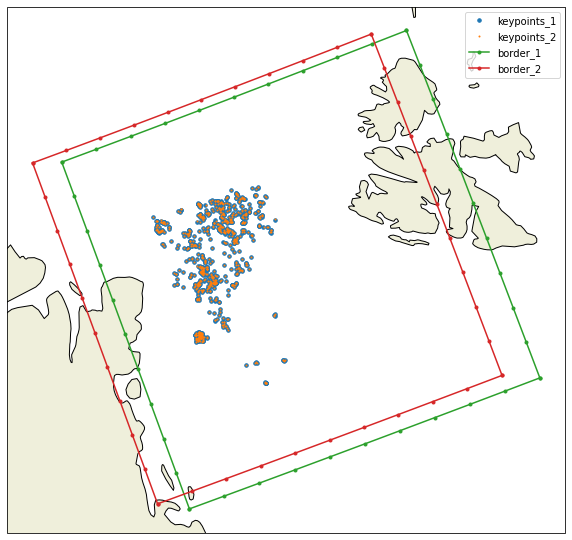

In [11]:
# Plot identified and matched keypoints in geographic coordinates

# convert row/column coordinates of matched features to lon/lat
lon1ft, lat1ft = n1.transform_points(c1, r1)
lon2ft, lat2ft = n3.transform_points(c2, r2)

# get lon/lat coordinates of the border of images
lon1b, lat1b = n1.get_border()
lon2b, lat2b = n3.get_border()


# get hi-res landmask
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70))
ax.add_feature(land_50m, zorder=0, edgecolor='black')
ax.plot(lon1ft, lat1ft, '.', label='keypoints_1', transform=ccrs.PlateCarree(), markersize=7)
ax.plot(lon2ft, lat2ft, '.', label='keypoints_2', transform=ccrs.PlateCarree(), markersize=2)
ax.plot(lon1b, lat1b, '.-', label='border_1', transform=ccrs.PlateCarree())
ax.plot(lon2b, lat2b, '.-', label='border_2', transform=ccrs.PlateCarree())
ax.legend()
plt.show()

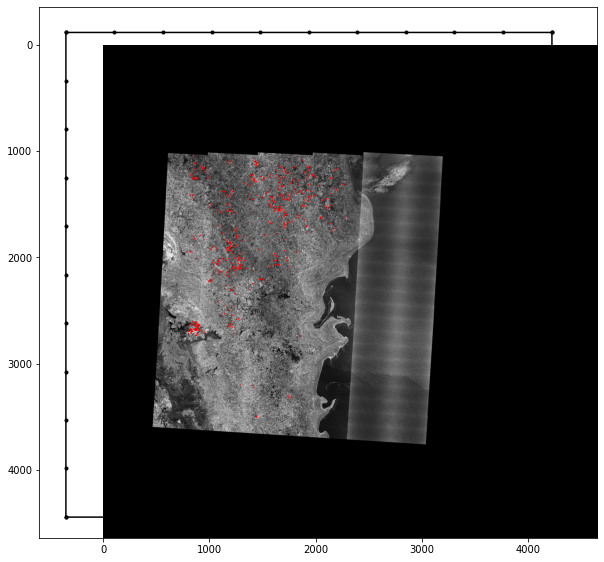

In [12]:

# Plot ice drift on top of image_1

# end points in image_1 coordinate system
n1c2, n1r2 = n1.transform_points(lon2ft, lat2ft, DstToSrc=1)

# ice drift components in image_1 coordinate system
dr = n1r2 - r1
dc = n1c2 - c1

# border of image_2 in image_1 coordinate system
n1lon2b, n1lat2b = n1.transform_points(lon2b, lat2b, DstToSrc=1)

# plot of ice drift. Arrows are 5 times longer than actual drift
plt.figure(figsize=(10,10))
plt.imshow(n1[1], cmap='gray')
plt.quiver(c1, r1, dc, dr, color='r', angles='xy', scale_units='xy', scale=0.5)
plt.plot(n1lon2b, n1lat2b, 'k.-')

plt.show()
#filename = '/home/jovyan/work/Icedrift/Nansen_algorithm/Data_and_output/Nansen_output/2500m/FT_example_HH#_1image.png'
#plt.savefig(filename, dpi=300, bbox_inches='tight')

In [13]:
import xarray as xr
data = xr.open_dataset("https://thredds.met.no/thredds/dodsC/fou-hi/barents_eps_eps/barents_eps_20230902T12Z.nc")


In [14]:
import xarray as xr
# Setting subset grid using image border coordinates from nanset object
# Open the remote dataset with model data
#data = xr.open_dataset("https://thredds.met.no/thredds/dodsC/fou-hi/barents_eps_eps/barents_eps_20230211T18Z.nc")
# Extract X and Y coordinates, as well as longitude and latitude values from the dataset
X = data['X']
Y = data['Y']
lon = data['lon']
lat = data['lat']

# Retrieve the proj4 string defining the Lambert Conformal projection of the dataset
proj4 = data.projection_lambert.proj4
print(proj4)

# Convert the proj4 string to a Nansat spatial reference object
srs = NSR(proj4)

#Get bound in rows and columns correspoding to the image borders set above
r,c = np.where((lon.data > min(lon1b))*(lon.data <  max(lon1b))*(lat.data >  min(lat1b))*(lat.data < max(lat1b)))
               
min_row, max_row, min_col, max_col = min(r), max(r), min(c), max(c)

+proj=lcc +lat_0=77.5 +lon_0=-25 +lat_1=77.5 +lat_2=77.5 +no_defs +R=6.371e+06


In [15]:
%store min_row
%store max_row
%store min_col
%store max_col
%store lon
%store lat

Stored 'min_row' (int64)
Stored 'max_row' (int64)
Stored 'min_col' (int64)
Stored 'max_col' (int64)
Stored 'lon' (DataArray)
Stored 'lat' (DataArray)


In [16]:
# Extract the subset grif out of the model grid based on the image bounds
#That grid and srs will be used for pattern matching ensuring the drift output aligns easily with the model data.
X_subset = X[min_col:max_col+1]
Y_subset = Y[min_row:max_row+1]
lon_subset = lon[min_row:max_row+1, min_col:max_col+1]
lat_subset = lat[min_row:max_row+1, min_col:max_col+1]


# Prepare coordinates for patern matching input
lon1pm = lon_subset.data
lat1pm = lat_subset.data

# Set up coordinates in meters for visualizing the pattern matching results.
x1pm, y1pm = np.meshgrid(X_subset, Y_subset)

In [17]:
%store X_subset
%store Y_subset

Stored 'X_subset' (DataArray)
Stored 'Y_subset' (DataArray)


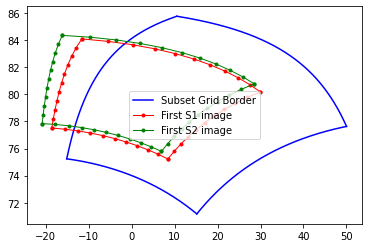

In [18]:
# Plot coverage of the first SAR1 image and subset grid imported from the model
# Top border
plt.plot(lon_subset[0, :], lat_subset[0, :], 'b-', label='Subset Grid Border')
# Bottom border
plt.plot(lon_subset[-1, :], lat_subset[-1, :], 'b-')
# Left border
plt.plot(lon_subset[:, 0], lat_subset[:, 0], 'b-')
# Right border
plt.plot(lon_subset[:, -1], lat_subset[:, -1], 'b-')

plt.plot(*n1.get_border(), '.-', label='First S1 image',markersize=6, linewidth=1, c = 'red')
plt.plot(*n3.get_border(), '.-', label='First S2 image', markersize=6, linewidth=1, c = 'green')
#plt.plot(*dom_pm.get_border(), '.-', label='ROI')
plt.legend()
plt.show()

#### UPdated pm function to calcualte SSIM - DOESN'T WORK

In [21]:
# Name:    pmlib.py
# Purpose: Container of Pattern Matching functions
# Authors:      Anton Korosov, Stefan Muckenhuber
# Created:      21.09.2016
# Copyright:    (c) NERSC 2016
# Licence:
# This file is part of SeaIceDrift.
# SeaIceDrift is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, version 3 of the License.
# http://www.gnu.org/licenses/gpl-3.0.html
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
from __future__ import absolute_import, print_function

import time
from multiprocessing import Pool

import numpy as np
from scipy import ndimage as nd
import matplotlib.pyplot as plt
from osgeo import gdal
import cv2

from nansat import NSR

from sea_ice_drift.lib import (interpolation_poly,
                               interpolation_near,
                               get_drift_vectors,
                               _fill_gpi)

shared_args = None
shared_kwargs = None

def get_hessian(ccm, hes_norm=True, hes_smth=False, **kwargs):
    """ Find Hessian of the input cross correlation matrix <ccm>

    Parameters
    ----------
    ccm : 2D numpy array, cross-correlation matrix
    hes_norm : bool, normalize Hessian by AVG and STD?
    hes_smth : bool, smooth Hessian?

    """
    if hes_smth:
        ccm2 = nd.filters.gaussian_filter(ccm, 1)
    else:
        ccm2 = ccm
    # Jacobian components
    dcc_dy, dcc_dx = np.gradient(ccm2)
    # Hessian components
    d2cc_dx2 = np.gradient(dcc_dx)[1]
    d2cc_dy2 = np.gradient(dcc_dy)[0]
    hes = np.hypot(d2cc_dx2, d2cc_dy2)
    if hes_norm:
        hes = (hes - np.median(hes)) / np.std(hes)

    return hes

def get_distance_to_nearest_keypoint(x1, y1, shape):
    ''' Return full-res matrix with distance to nearest keypoint in pixels
    Parameters
    ----------
        x1 : 1D vector - X coordinates of keypoints
        y1 : 1D vector - Y coordinates of keypoints
        shape : shape of image
    Returns
    -------
        dist : 2D numpy array - image with distances
    '''
    seed = np.zeros(shape, dtype=bool)
    seed[np.uint16(y1), np.uint16(x1)] = True
    dist = nd.distance_transform_edt(~seed,
                                    return_distances=True,
                                    return_indices=False)
    return dist

def get_initial_rotation(n1, n2):
    ''' Returns angle <alpha> of rotation between two Nansat <n1>, <n2>'''
    corners_n2_lons, corners_n2_lats = n2.get_corners()
    corner0_n2_x1, corner0_n2_y1 = n1.transform_points([corners_n2_lons[0]], [corners_n2_lats[0]], 1)
    corner1_n2_x1, corner1_n2_y1 = n1.transform_points([corners_n2_lons[1]], [corners_n2_lats[1]], 1)
    b = corner1_n2_x1 - corner0_n2_x1
    a = corner1_n2_y1 - corner0_n2_y1
    alpha = np.degrees(np.arctan2(b, a)[0])
    return alpha

def get_template(img, c, r, a, s, rot_order=0, **kwargs):
    """ Get rotated and shifted square template
    Parameters
    ----------
        img : ndarray, input image
        c : float, center column coordinate (pixels)
        r : float, center row coordinate (pixels)
        a : float, rotation angle (degrees)
        s : odd int, template size (width and height)
        order : int, transformation order
    Returns
    -------
        t : ndarray (s,s)[np.uint8], rotated template

    """
    # center on output template
    tc = int(s / 2.) + 1
    tc = np.array([tc, tc])

    a = np.radians(a)
    transform = np.array([[np.cos(a), -np.sin(a)],[np.sin(a), np.cos(a)]])
    offset = np.array([r, c]) - tc.dot(transform)

    t = nd.interpolation.affine_transform(
        img, transform.T, order=rot_order, offset=offset, output_shape=(s, s), cval=0.0, output=np.uint8)

    return t

# Added for ssim experiment
from skimage.metrics import structural_similarity as compare_ssim


def rotate_and_match(img1, c1, r1, img_size, image2, alpha0,
                     angles=[-3,0,3],
                     mtype=cv2.TM_CCOEFF_NORMED,
                     template_matcher=cv2.matchTemplate,
                     mcc_norm=False,
                     **kwargs):
    
    
    ''' Rotate template in a range of angles and run MCC for each
    Parameters
    ----------
        im1 : 2D numpy array - original image 1
        c1 : float - column coordinate of center on img1
        r1 : float - row coordinate of center on img1
        img_size : size of template
        image : np.uint8, subset from image 2
        alpha0 : float - angle of rotation between two SAR scenes
        angles : list - which angles to test
        mtype : int - type of cross-correlation
        template_matcher : func - function to use for template matching
        mcc_norm : bool, normalize MCC by AVG and STD ?
        kwargs : dict, params for get_hessian
    Returns
    -------
        dc : int - column displacement of MCC
        dr : int - row displacement of MCC
        best_a : float - angle of MCC
        best_r : float - MCC
        best_h : float - Hessian at highest MCC point
        best_result : float ndarray - cross correlation matrix
        best_template : uint8 ndarray - best rotated template

    '''
    res_shape = [image2.shape[0] - img_size +1]*2
    best_r = -np.inf
    for angle in angles:
        template = get_template(img1, c1, r1, angle-alpha0, img_size, **kwargs)
        if ((template.min() == 0) or
            (template.shape[0] < img_size or template.shape[1] < img_size)):
            return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

        result = template_matcher(image2, template, mtype)

        ij = np.unravel_index(np.argmax(result), result.shape)

        if result.max() > best_r:
            best_r = result.max()
            best_a = angle
            best_result = result
            best_template = template
            best_ij = ij

    best_h = get_hessian(best_result, **kwargs)[best_ij]
    dr = best_ij[0] - (image2.shape[0] - template.shape[0]) / 2.
    dc = best_ij[1] - (image2.shape[1] - template.shape[1]) / 2.

    if mcc_norm:
        best_r = (best_r - np.median(best_result)) / np.std(best_result)
    
    # Added for ssim experiment
    # Now, after finding the best match using cross-correlation, compute SSIM
    best_ssim = compare_ssim(best_template, image2[best_ij[0]:best_ij[0]+img_size, best_ij[1]:best_ij[1]+img_size], data_range=image2.max() - image2.min())

    return dc, dr, best_a, best_r, best_h, best_result, best_template, best_ssim #best_ssim added for ssim experiment

def use_mcc(c1, r1, c2fg, r2fg, border, img1, img2, img_size, alpha0, **kwargs):
    """ Apply MCC algorithm for one point

    Parameters
    ----------
        c1 : float, column coordinate on image 1
        r1 : float, row coordinate on image 1
        c2fg : int, first guess column coordinate on image 2
        r2fg : int, first guess row coordinate on image 2
        border : int, searching distance (border around template)
        img1 : 2D array - full szie image 1
        img2 : 2D array - full szie image 2
        img_size : int, template size
        alpha0 : float, rotation between two images
        kwargs : dict, params for rotate_and_match, get_template, get_hessian
    Returns
    -------
        x2 : float, result X coordinate on image 2
        y2 : float, result X coordinate on image 2
        a : float, angle that gives highest MCC
        r : float, MCC
        h : float, Hessian of CC at MCC point

    """
    hws = int(img_size / 2.)
    image = img2[int(r2fg-hws-border):int(r2fg+hws+border+1),
                 int(c2fg-hws-border):int(c2fg+hws+border+1)]
    
    #Upded for SSIM
    dc, dr, best_a, best_r, best_h, best_result, best_template, best_ssim  = rotate_and_match(img1, c1, r1,
                                                      img_size,
                                                      image,
                                                      alpha0,
                                                      **kwargs)
    c2 = c2fg + dc
    r2 = r2fg + dr

    return c2, r2, best_a, best_r, best_h, best_ssim # Added for ssim

def use_mcc_mp(i):
    """ Use MCC
    Uses global variables where first guess and images are stored
    Parameters
    ---------
        i : int, index of point
    Returns
    -------
        c2 : float, result X coordinate on image 2
        r2 : float, result X coordinate on image 2
        a : float, angle that gives highest MCC
        r : float, MCC
        h : float, Hessian of CC at MCC point

    """
    global shared_args, shared_kwargs

    # structure of shared_args:
    # c1pm1i, r1pm1i, c2fg, r2fg, brd2, img1, img2, img_size, alpha0, kwargs
    '''
    c2, r2, a, r, h = use_mcc(shared_args[0][i],
                              shared_args[1][i],
                              shared_args[2][i],
                              shared_args[3][i],
                              shared_args[4][i],
                              shared_args[5],
                              shared_args[6],
                              shared_args[7],
                              shared_args[8],
                              **shared_kwargs)
    '''
    #new one to add ssim
    c2, r2, a, r, h, best_ssim = use_mcc(shared_args[0][i], 
                                    shared_args[1][i], 
                                    shared_args[2][i], 
                                    shared_args[3][i], 
                                    shared_args[4][i], 
                                    shared_args[5], 
                                    shared_args[6], 
                                    shared_args[7], 
                                    shared_args[8], 
                                    **shared_kwargs)

    
    if i % 100 == 0:
        print('%02.0f%% %07.1f %07.1f %07.1f %07.1f %+05.1f %04.2f %04.2f' % (
            100 * float(i) / len(shared_args[0]),
            shared_args[0][i], shared_args[1][i], c2, r2, a, r, h), end='\r')
    return c2, r2, a, r, h, best_ssim

def prepare_first_guess(c2pm1, r2pm1, n1, c1, r1, n2, c2, r2, img_size,
                        min_fg_pts=5,
                        min_border=20,
                        max_border=50,
                        old_border=True, **kwargs):
    ''' For the given intial coordinates estimate the approximate final coordinates
    Parameters
    ---------
        c2_pm1 : 1D vector, initial PM column on image 2
        r2_pm1 : 1D vector, initial PM rows of image 2
        n1 : Nansat, the fist image with 2D array
        c1 : 1D vector, initial FT columns on img1
        r1 : 1D vector, initial FT rows on img2
        n2 : Nansat, the second image with 2D array
        c2 : 1D vector, final FT columns on img2
        r2 : 1D vector, final FT rows on img2
        img_size : int, size of template
        min_fg_pts : int, minimum number of fist guess points
        min_border : int, minimum searching distance
        max_border : int, maximum searching distance
        old_border : bool, use old border selection algorithm?
        **kwargs : parameters for:
            x2y2_interpolation_poly
            x2y2_interpolation_near
    Returns
    -------
        c2_fg : 1D vector, approximate final PM columns on img2 (first guess)
        r2_fg : 1D vector, approximate final PM rows on img2 (first guess)
        border : 1D vector, searching distance
    '''
    n2_shape = n2.shape()
    # convert initial FT points to coordinates on image 2
    lon1, lat1 = n1.transform_points(c1, r1)
    c1n2, r1n2 = n2.transform_points(lon1, lat1, 1)

    # interpolate 1st guess using 2nd order polynomial
    c2p2, r2p2 = np.round(interpolation_poly(c1n2, r1n2, c2, r2, c2pm1, r2pm1, **kwargs))

    # interpolate 1st guess using griddata
    c2fg, r2fg = np.round(interpolation_near(c1n2, r1n2, c2, r2, c2pm1, r2pm1, **kwargs))

    # TODO:
    # Now border is proportional to the distance to the point
    # BUT it assumes that:
    #     close to any point error is small, and
    #     error varies between points
    # What if error does not vary with distance from the point?
    # Border can be estimated as error of the first guess
    # (x2 - x2_predicted_with_polynom) gridded using nearest neighbour.
    if old_border:
        # find distance to nearest neigbour and create border matrix
        border_img = get_distance_to_nearest_keypoint(c2, r2, n2_shape)
        border = np.zeros(c2pm1.size) + max_border
        gpi = ((c2pm1 >= 0) * (c2pm1 < n2_shape[1]) *
               (r2pm1 >= 0) * (r2pm1 < n2_shape[0]))
        border[gpi] = border_img[np.round(r2pm1[gpi]).astype(np.int16),
                                 np.round(c2pm1[gpi]).astype(np.int16)]
    else:
        c2tst, r2tst = interpolation_poly(c1n2, r1n2, c2, r2, c1n2, r1n2, **kwargs)
        c2dif, r2dif = interpolation_near(c1n2, r1n2,
                                               c2-c2tst, r2-r2tst,
                                               c2pm1, r2pm1,
                                               **kwargs)
        border = np.hypot(c2dif, r2dif)

    # define searching distance
    border[border < min_border] = min_border
    border[border > max_border] = max_border
    border[np.isnan(c2fg)] = max_border
    border = np.floor(border)

    # define FG based on P2 and GD
    c2fg[np.isnan(c2fg)] = c2p2[np.isnan(c2fg)]
    r2fg[np.isnan(r2fg)] = r2p2[np.isnan(r2fg)]

    return c2fg, r2fg, border

def pattern_matching(lon_pm1, lat_pm1,
                     n1, c1, r1, n2, c2, r2,
                     margin=0,
                     img_size=35,
                     threads=5,
                     srs='+proj=latlong +datum=WGS84 +ellps=WGS84 +no_defs',
                     **kwargs):
    ''' Run Pattern Matching Algorithm on two images
    Parameters
    ---------
        lon_pm1 : 1D vector
            longitudes of destination initial points
        lat_pm1 : 1D vector
            latitudes of destination initial points
        n1 : Nansat
            the fist image with 2D array
        c1 : 1D vector
            initial FT columns on img1
        r1 : 1D vector
            initial FT rows on img2
        n2 : Nansat
            the second image with 2D array
        c2 : 1D vector
            final FT columns on img2
        r2 : 1D vector
            final FT rows on img2
        img_size : int
            size of template
        threads : int
            number of parallel threads
        srs: str
            destination spatial refernce system of the drift vectors (proj4 or WKT)
        **kwargs : optional parameters for:
            prepare_first_guess
                min_fg_pts : int, minimum number of fist guess points
                min_border : int, minimum searching distance
                max_border : int, maximum searching distance
                old_border : bool, use old border selection algorithm?
            rotate_and_match
                angles : list - which angles to test
                mtype : int - type of cross-correlation
                template_matcher : func - function to use for template matching
                mcc_norm : bool, normalize MCC by AVG and STD ?
            get_template
                rot_order : resampling order for rotation
            get_hessian
                hes_norm : bool, normalize Hessian by AVG and STD?
                hes_smth : bool, smooth Hessian?
            get_drift_vectors
                nsr: Nansat.NSR(), projection that defines the grid
    Returns
    -------
        u : 1D vector
            eastward ice drift displacement [destination SRS units]
        v : 1D vector
            northward ice drift displacement [destination SRS units]
        a : 1D vector
            angle that gives the highes MCC
        r : 1D vector
            Maximum cross correlation (MCC)
        h : 1D vector
            Hessian of CC at MCC point
        lon2_dst : 1D vector
            longitude of results on image 2
        lat2_dst : 1D vector
            latitude  of results on image 2
    '''
    t0 = time.time()
    img1, img2 = n1[1], n2[1]
    dst_shape = lon_pm1.shape

    # coordinates of starting PM points on image 2
    c2pm1, r2pm1 = n2.transform_points(lon_pm1.flatten(), lat_pm1.flatten(), 1)

    # integer coordinates of starting PM points on image 2
    c2pm1i, r2pm1i = np.round([c2pm1, r2pm1])

    # fake cooridinates for debugging
    #c2pm1, r2pm1 = np.meshgrid(np.arange(c2pm1i.min(), c2pm1i.max(), 25),
    #                           np.arange(c2pm1i.min(), c2pm1i.max(), 25))
    #dst_shape = c2pm1.shape
    #c2pm1i, r2pm1i = np.round([c2pm1.flatten(), r2pm1.flatten()])

    # coordinates of starting PM points on image 1 (correposond to integer coordinates in img2)
    lon1i, lat1i = n2.transform_points(c2pm1i, r2pm1i)
    c1pm1i, r1pm1i = n1.transform_points(lon1i, lat1i, 1)

    # approximate final PM points on image 2 (the first guess)
    c2fg, r2fg, brd2 = prepare_first_guess(c2pm1i, r2pm1i, n1, c1, r1, n2, c2, r2, img_size, **kwargs)

    # find valid input points
    hws = round(img_size / 2) + 1
    hws_hypot = np.hypot(hws, hws)
    gpi = ((c2fg-brd2-hws-margin > 0) *
           (r2fg-brd2-hws-margin > 0) *
           (c2fg+brd2+hws+margin < n2.shape()[1]) *
           (r2fg+brd2+hws+margin < n2.shape()[0]) *
           (c1pm1i-hws_hypot-margin > 0) *
           (r1pm1i-hws_hypot-margin > 0) *
           (c1pm1i+hws_hypot+margin < n1.shape()[1]) *
           (r1pm1i+hws_hypot+margin < n1.shape()[0]))

    alpha0 = get_initial_rotation(n1, n2)

    def _init_pool(*args):
        """ Initialize shared data for multiprocessing """
        global shared_args, shared_kwargs
        shared_args = args[:9]
        shared_kwargs = args[9]

    if threads <= 1:
        # run MCC without threads
        _init_pool(c1pm1i[gpi], r1pm1i[gpi], c2fg[gpi], r2fg[gpi], brd2[gpi], img1, img2, img_size, alpha0, kwargs)
        results = [use_mcc_mp(i) for i in range(len(gpi[gpi]))]
    else:
        # run MCC in multiple threads
        p = Pool(threads, initializer=_init_pool,
                initargs=(c1pm1i[gpi], r1pm1i[gpi], c2fg[gpi], r2fg[gpi], brd2[gpi], img1, img2, img_size, alpha0, kwargs))
        results = p.map(use_mcc_mp, range(len(gpi[gpi])))
        p.close()
        p.terminate()
        p.join()
        del p

    print('\n', 'Pattern matching - OK! (%3.0f sec)' % (time.time() - t0))
    if len(results) == 0:
        lon2_dst = np.zeros(dst_shape) + np.nan
        lat2_dst = np.zeros(dst_shape) + np.nan
        u = np.zeros(dst_shape) + np.nan
        v = np.zeros(dst_shape) + np.nan
        a = np.zeros(dst_shape) + np.nan
        r = np.zeros(dst_shape) + np.nan
        h = np.zeros(dst_shape) + np.nan
        best_ssim = np.zeros(dst_shape) + np.nan
        lon_pm2_grd = np.zeros(dst_shape) + np.nan
        lat_pm2_grd = np.zeros(dst_shape) + np.nan
    else:
        results = np.array(results)

        # coordinates of final PM points on image 2 (correspond to integer intial coordinates)
        c2pm2i = results[:,0]
        r2pm2i = results[:,1]

        # coordinatesof final PM points on image 2 (correspond to real intial coordinates)
        dci, dri, = c2pm1 - c2pm1i,  r2pm1 - r2pm1i
        c2pm2, r2pm2 = c2pm2i + dci[gpi], r2pm2i + dri[gpi]

        # coordinates of initial PM points on destination grid and coordinates system
        xpm1, ypm1 = n2.transform_points(c2pm1, r2pm1, 0, NSR(srs))
        xpm1_grd = xpm1.reshape(dst_shape)
        ypm1_grd = ypm1.reshape(dst_shape)

        # coordinates of final PM points on destination grid and coordinates system
        xpm2, ypm2 = n2.transform_points(c2pm2, r2pm2, 0, NSR(srs))
        xpm2_grd = _fill_gpi(dst_shape, gpi, xpm2)
        ypm2_grd = _fill_gpi(dst_shape, gpi, ypm2)
        lon_pm2, lat_pm2 = n2.transform_points(c2pm2, r2pm2, 0)
        lon_pm2_grd = _fill_gpi(dst_shape, gpi, lon_pm2)
        lat_pm2_grd = _fill_gpi(dst_shape, gpi, lat_pm2)

        # speed vectors on destination grid and coordinates system
        u = xpm2_grd - xpm1_grd
        v = ypm2_grd - ypm1_grd

        # angle, correlation and hessian on destination grid
        a = results[:,2]
        r = results[:,3]
        h = results[:,4]
        best_ssim = results[:,5]  #Added for ssim
        a = _fill_gpi(dst_shape, gpi, a)
        r = _fill_gpi(dst_shape, gpi, r)
        h = _fill_gpi(dst_shape, gpi, h)
        best_ssim = _fill_gpi(dst_shape, gpi, best_ssim)

    return u, v, a, r, h, best_ssim, lon_pm2_grd, lat_pm2_grd


#### Run pattern matching

In [22]:
## Run Pattern Matching for each element in lon1pm/lat1pm matrix
# ice displacement upm and vpm are returned in meters in Stereographic projection
upm, vpm, apm, rpm, hpm,best_ssim, lon2pm, lat2pm = pattern_matching(lon1pm, lat1pm, n1, c1, r1, n3, c2, r2,
                                                          srs=srs.ExportToProj4(),
                                                           min_border=100,
                                                           max_border=100,
                                                           angles=[-12, -9,-6, -3, 0, 3, 6, 9, 12])

/tmp/ipykernel_21459/4238955295.py:112: DeprecationWarning: Please use `affine_transform` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  t = nd.interpolation.affine_transform(
/tmp/ipykernel_21459/4238955295.py:112: DeprecationWarning: Please use `affine_transform` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  t = nd.interpolation.affine_transform(
/tmp/ipykernel_21459/4238955295.py:112: DeprecationWarning: Please use `affine_transform` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  t = nd.interpolation.affine_transform(
/tmp/ipykernel_21459/4238955295.py:112: DeprecationWarning: Please use `affine_transform` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  t = nd.interpolation.affine_transform(
/tmp/ipykernel_21459/4238955295.py:112: DeprecationWarning: Please use `affine_transform` from t

/tmp/ipykernel_21459/4238955295.py:57: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


/tmp/ipykernel_21459/4238955295.py:57: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


/tmp/ipykernel_21459/4238955295.py:57: RuntimeWarning: invalid value encountered in divide
  hes = (hes - np.median(hes)) / np.std(hes)


100% 02938.2 00031.7 03189.0 00050.0 -12.0 1.00 0nan33% 01048.2 02891.7 01486.0 03093.0 -06.0 0.20 7.2438% 03095.2 02688.7 03346.0 02706.0 -12.0 0.00 0nan
 Pattern matching - OK! (176 sec)


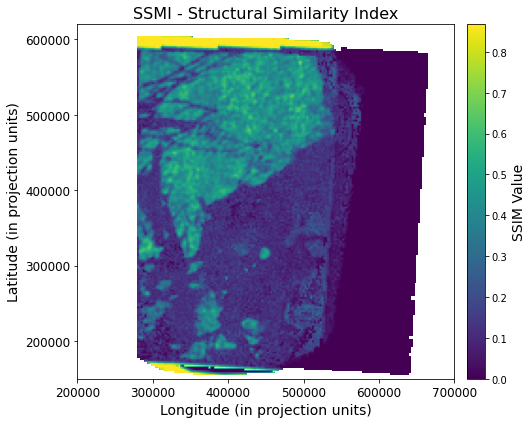

In [42]:
# plot retrieved matrices
fig, ax = plt.subplots(1,1, figsize=(18,6))

# Set title and labels
ax.set_title('SSMI - Structural Similarity Index', fontsize=16)
ax.set_xlabel('Longitude (in projection units)', fontsize=14)
ax.set_ylabel('Latitude (in projection units)', fontsize=14)

# Display the data with a colormap that provides better contrast and understanding
im = ax.imshow(best_ssim, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower', cmap='viridis')

# Add a colorbar with a label
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.01)
cbar.set_label('SSIM Value', fontsize=14)

# Adjust tick label size
ax.tick_params(axis='both', labelsize=12)
ax.set_xlim([0.2e6, 0.7e6]) 
ax.set_ylim([0.15e6, 0.62e6])

plt.tight_layout()
plt.show()


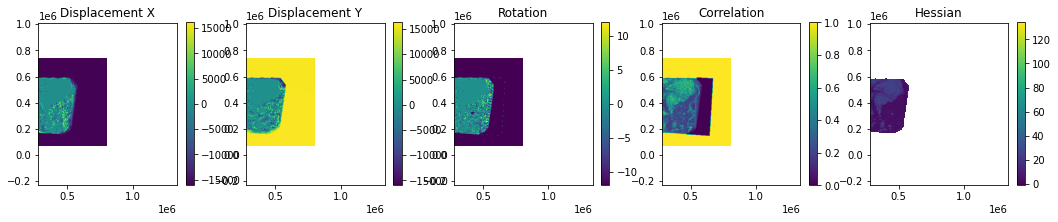

In [22]:
# plot retrieved matrices
titles = ['Displacement X', 'Displacement Y', 'Rotation', 'Correlation', 'Hessian']
fig, ax = plt.subplots(1,5, figsize=(18,3))
for i, a in enumerate([upm, vpm, apm, rpm, hpm]):
    ax[i].set_title(titles[i])
    im = ax[i].imshow(a, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower')
    plt.colorbar(im, ax=ax[i])

plt.show()

In [43]:
# Model domain to reproject SAR image from 3996
model_d = Domain(srs, f'-te {min(X_subset.data)} {min(Y_subset.data)} {max(X_subset.data)} {max(Y_subset.data)} -tr 100 100')
# reproject n1 for visualizing SAR image in the same projection as model data

# Get n for vizualizaton and reprojecting
n0.reproject(model_d) 
n0b1 = n0[1]
n0.undo()

n1.reproject(model_d) 
n1b1 = n1[1]
n1.undo()

n2.reproject(model_d) 
n2b1 = n2[1]
n2.undo()

n3.reproject(model_d)
n3b1 = n3[1]
n3.undo()

#### Plotting data with hessian

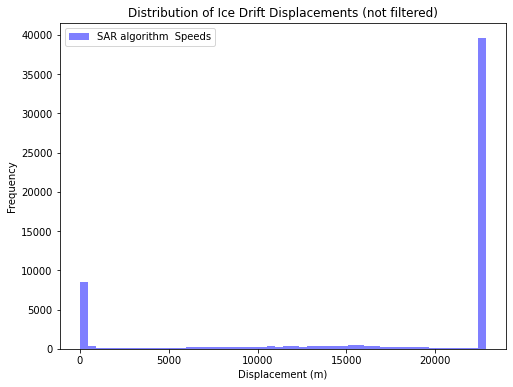

In [24]:
disp_alg = np.sqrt((upm**2+vpm**2))

disp_alg = disp_alg.flatten()


plt.figure(figsize=(8,6))



# Plotting Reference Speed
plt.hist(disp_alg, bins=50, color='blue', alpha=0.5, label='SAR algorithm  Speeds')

plt.xlabel('Displacement (m)')
plt.ylabel('Frequency')
plt.title('Distribution of Ice Drift Displacements (not filtered)')
plt.legend()
plt.show()



In [52]:
# !!! I need to use gpi from SAR1-SAR2 experiment to see what could go wrong for all good pixels

Number of True values without filtering : 8456


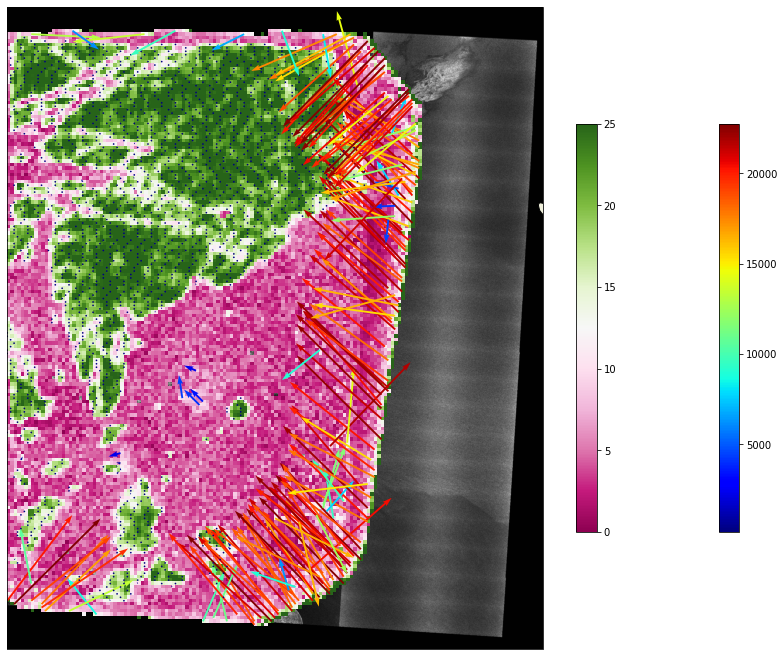

In [54]:
u = upm #/ delta_t
v = vpm #/ delta_t
speed = np.sqrt((v**2+u**2)) 

# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Create a figure with three subplots side by side
plt.figure(figsize=(15,15))
ax =plt.axes(projection=crs) 

# Figure 1

# filter vectors with hessian value
gpi = (hpm > 9) 
num_true_values = np.sum(gpi.data)
print(f"Number of True values without filtering : {num_true_values}")



ax.imshow(n1b1, cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
quiv1 = ax.quiver(x1pm[gpi][::4], y1pm[gpi][::4], u[gpi][::4], v[gpi][::4], speed[gpi][::4], scale=100000, cmap='jet', width=0.0035)
#quiv1 = ax.quiver(x1pm[gpi][::1], y1pm[gpi][::1], u[gpi][::1], v[gpi][::1], speed[gpi][::1], scale=2, cmap='jet', width=0.0035)
#ax.set_title('Ice Drift Speed before filtering[m/s]')
#ax.add_feature(land_50m, edgecolor='black')
#ax.set_xlim([x1pm.min(), x1pm.max()])
#ax.set_ylim([y1pm.min(), y1pm.max()])
ax.set_xlim([x1pm.min(), x1pm.max()-670000])
ax.set_ylim([y1pm.min()+370000, y1pm.max()-400000])
plt.colorbar(quiv1, ax=ax, orientation='vertical', shrink=0.5)

# Filter out values of hpm 
filtered_hpm = np.where(hpm > 0, hpm, np.nan)
h_img = ax.imshow(filtered_hpm, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower', cmap='PiYG', alpha=1, vmin=0, vmax=25)
#ax.set_title('Hessian > 9')
ax.add_feature(land_50m, edgecolor='black')
ax.set_xlim([x1pm.min(), x1pm.max()-670000])
ax.set_ylim([y1pm.min()+370000, y1pm.max()-400000])
plt.colorbar(h_img, ax=ax, shrink=0.5)


plt.show()


Number of True values in gpi before filtering: 8923


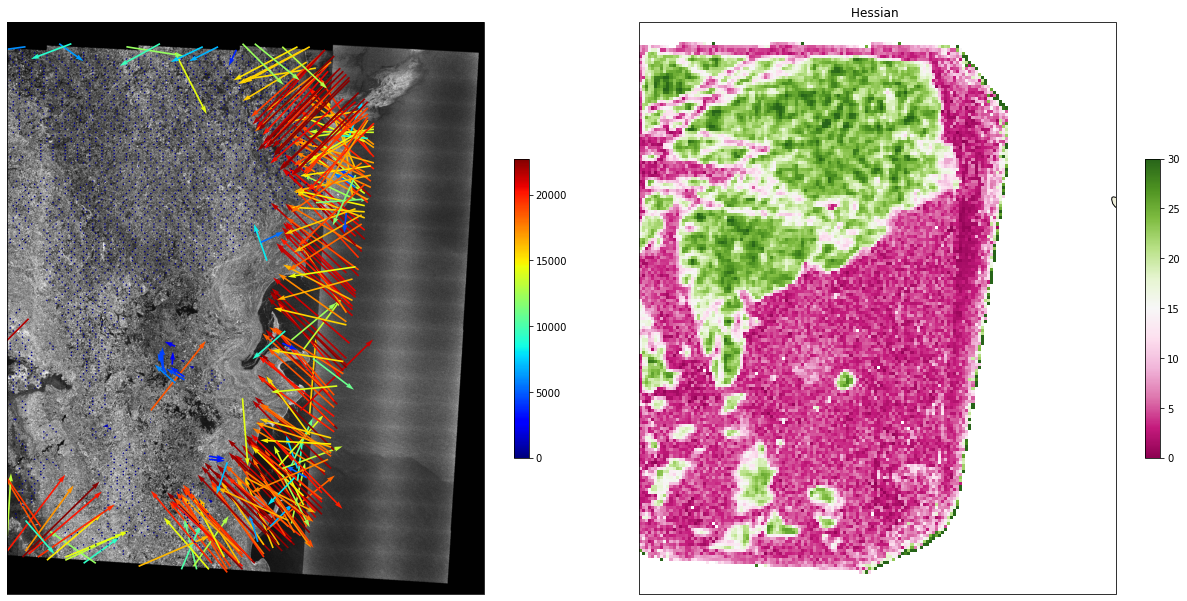

In [53]:
# without steps for visualizing 
u = upm #/ delta_t
v = vpm #/ delta_t
speed = np.sqrt((v**2+u**2)) 

# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22,11), subplot_kw={'projection': crs})

# Figure 1

# filter vectors with hessian value
gpi = (hpm > 8)
num_true_values = np.sum(gpi.data)
print(f"Number of True values in gpi before filtering: {num_true_values}")

ax1.imshow(n1b1, cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
quiv1 = ax1.quiver(x1pm[gpi][::4], y1pm[gpi][::4], u[gpi][::4], v[gpi][::4], speed[gpi][::4], scale=100000, cmap='jet', width=0.0035)
#quiv1 = ax.quiver(x1pm[gpi][::1], y1pm[gpi][::1], u[gpi][::1], v[gpi][::1], speed[gpi][::1], scale=100000, cmap='jet', width=0.0035)
#ax1.set_title('Ice Drift Speed before filtering[m/s]')
#ax1.add_feature(land_50m, edgecolor='black')
#ax1.set_xlim([x1pm.min(), x1pm.max()])
#ax1.set_ylim([y1pm.min(), y1pm.max()])
ax1.set_xlim([x1pm.min(), x1pm.max()-670000])
ax1.set_ylim([y1pm.min()+370000, y1pm.max()-400000])
plt.colorbar(quiv1, ax=ax1, orientation='vertical', shrink=0.5)



#  Figure 2

# Filter out values of hpm 
filtered_hpm = np.where(hpm > 0, hpm, np.nan)
h_img = ax2.imshow(filtered_hpm, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower', cmap='PiYG', alpha=1, vmin=0, vmax=30)
ax2.set_title('Hessian ')
ax2.add_feature(land_50m, edgecolor='black')
ax2.set_xlim([x1pm.min(), x1pm.max()-670000])
ax2.set_ylim([y1pm.min()+370000, y1pm.max()-400000])
plt.colorbar(h_img, ax=ax2, shrink=0.5)



# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.06)  


#plt.tight_layout()
plt.show()



Number of True values in gpi before filtering: 8923


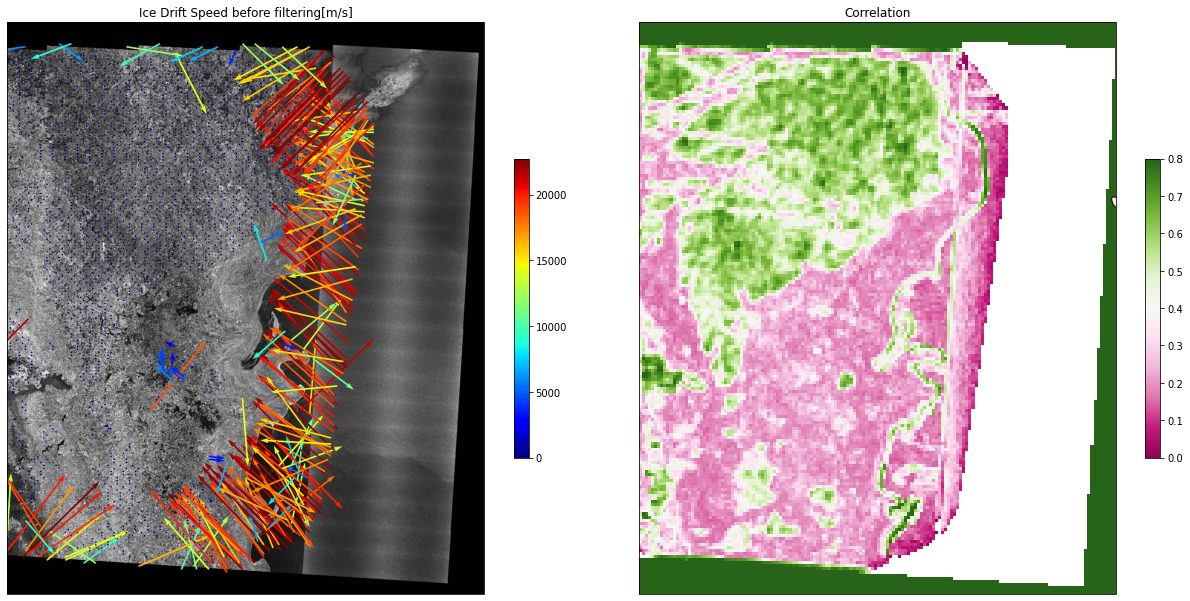

In [52]:
# without steps for visualizing 
#dayssec = total_time_diff

# compute ice drift speed [m/s]
#delta_t = dayssec #in seconds
u = upm #/ delta_t
v = vpm# / delta_t
speed = np.sqrt((v**2+u**2)) 

# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22,11), subplot_kw={'projection': crs})

# Figure 1

# filter vectors with hessian value
gpi = (hpm > 8)
num_true_values = np.sum(gpi.data)
print(f"Number of True values in gpi before filtering: {num_true_values}")

ax1.imshow(n1b1, cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
quiv1 = ax1.quiver(x1pm[gpi][::4], y1pm[gpi][::4], u[gpi][::4], v[gpi][::4], speed[gpi][::4], scale=100000, cmap='jet', width=0.0035)
#quiv1 = ax.quiver(x1pm[gpi][::1], y1pm[gpi][::1], u[gpi][::1], v[gpi][::1], speed[gpi][::1], scale=100000, cmap='jet', width=0.0035)
ax1.set_title('Ice Drift Speed before filtering[m/s]')
#ax1.add_feature(land_50m, edgecolor='black')
#ax1.set_xlim([x1pm.min(), x1pm.max()])
#ax1.set_ylim([y1pm.min(), y1pm.max()])
ax1.set_xlim([x1pm.min(), x1pm.max()-670000])
ax1.set_ylim([y1pm.min()+370000, y1pm.max()-400000])
plt.colorbar(quiv1, ax=ax1, orientation='vertical', shrink=0.5)



#  Figure 2

# Filter out values of hpm 
filtered_rpm = np.where(rpm > 0, rpm, np.nan)
h_img = ax2.imshow(filtered_rpm, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower', cmap='PiYG', alpha=1, vmin=0, vmax=0.8)
ax2.set_title('Correlation')
ax2.add_feature(land_50m, edgecolor='black')
ax2.set_xlim([x1pm.min(), x1pm.max()-670000])
ax2.set_ylim([y1pm.min()+370000, y1pm.max()-400000])
plt.colorbar(h_img, ax=ax2, shrink=0.5)



# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.06)  


#plt.tight_layout()
plt.show()



Number of True values in gpi before filtering: 8923


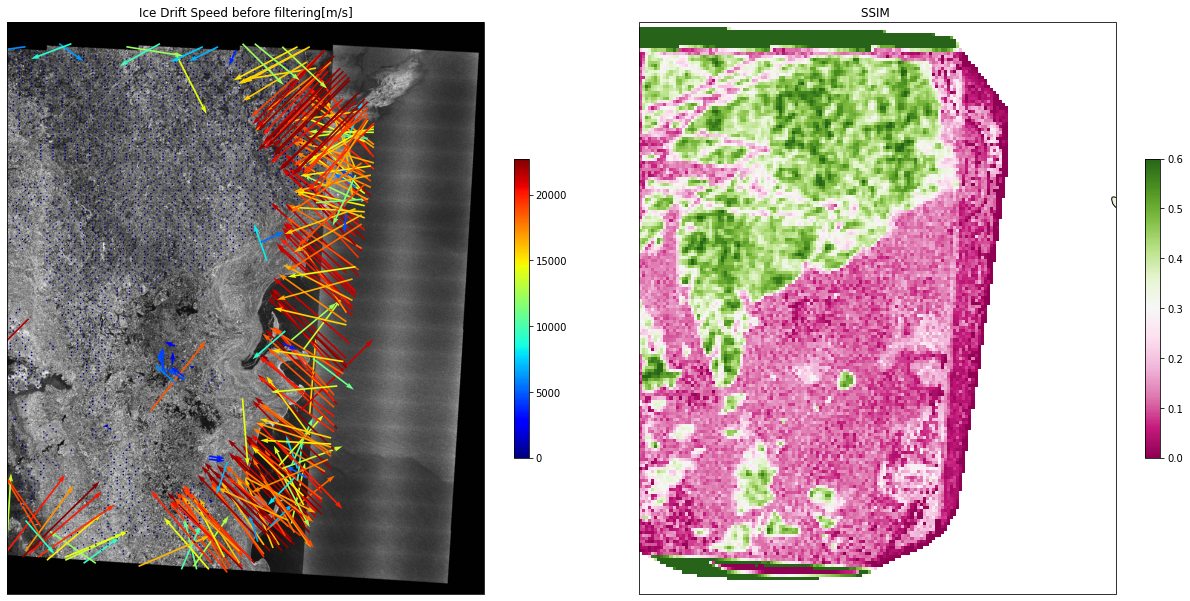

In [51]:
# without steps for visualizing 
#dayssec = total_time_diff

# compute ice drift speed [m/s]
#delta_t = dayssec #in seconds
u = upm #/ delta_t
v = vpm# / delta_t
speed = np.sqrt((v**2+u**2)) 

# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22,11), subplot_kw={'projection': crs})

# Figure 1

# filter vectors with hessian value
gpi = (hpm > 8)
num_true_values = np.sum(gpi.data)
print(f"Number of True values in gpi before filtering: {num_true_values}")

ax1.imshow(n1b1, cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
quiv1 = ax1.quiver(x1pm[gpi][::4], y1pm[gpi][::4], u[gpi][::4], v[gpi][::4], speed[gpi][::4], scale=100000, cmap='jet', width=0.0035)
#quiv1 = ax.quiver(x1pm[gpi][::1], y1pm[gpi][::1], u[gpi][::1], v[gpi][::1], speed[gpi][::1], scale=100000, cmap='jet', width=0.0035)
ax1.set_title('Ice Drift Speed before filtering[m/s]')
#ax1.add_feature(land_50m, edgecolor='black')
#ax1.set_xlim([x1pm.min(), x1pm.max()])
#ax1.set_ylim([y1pm.min(), y1pm.max()])
ax1.set_xlim([x1pm.min(), x1pm.max()-670000])
ax1.set_ylim([y1pm.min()+370000, y1pm.max()-400000])
plt.colorbar(quiv1, ax=ax1, orientation='vertical', shrink=0.5)



#  Figure 2

# Filter out values of hpm 
filtered_ssim = np.where(best_ssim > 0, best_ssim, np.nan)
h_img = ax2.imshow(filtered_ssim, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='lower', cmap='PiYG', alpha=1, vmin=0, vmax=0.6)
ax2.set_title('SSIM ')
ax2.add_feature(land_50m, edgecolor='black')
ax2.set_xlim([x1pm.min(), x1pm.max()-670000])
ax2.set_ylim([y1pm.min()+370000, y1pm.max()-400000])
plt.colorbar(h_img, ax=ax2, shrink=0.5)



# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.06)  


#plt.tight_layout()
plt.show()



Number of True values without filtering : 8893


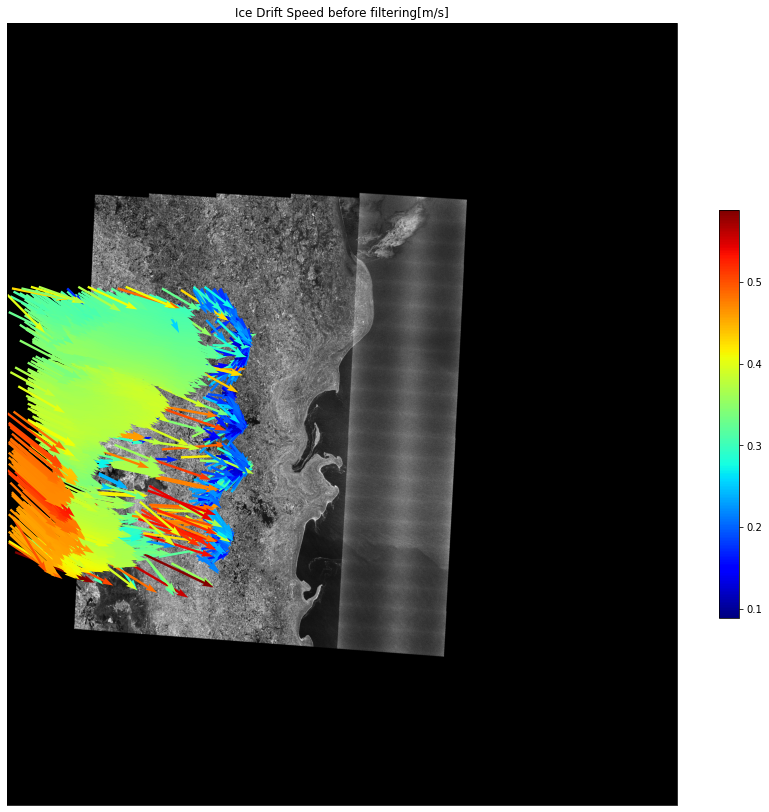

In [55]:
dayssec = total_time_diff

# compute ice drift speed [m/s]
delta_t = dayssec #in seconds
u = upm / delta_t
v = vpm / delta_t
speed = np.sqrt((v**2+u**2)) 

# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Create a figure with three subplots side by side
plt.figure(figsize=(15,15))
ax =plt.axes(projection=crs) 

# Figure 1

# filter vectors with hessian value
gpi = (hpm > 8) 
num_true_values = np.sum(gpi.data)
print(f"Number of True values without filtering : {num_true_values}")

# Plot the image on the first subplot
#
ax.imshow(a1, cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
quiv1 = ax.quiver(x1pm[gpi][::4], y1pm[gpi][::4], u[gpi][::4], v[gpi][::4], speed[gpi][::4], scale=5, cmap='jet', width=0.0035)
#quiv1 = ax.quiver(x1pm[gpi][::1], y1pm[gpi][::1], u[gpi][::1], v[gpi][::1], speed[gpi][::1], scale=2, cmap='jet', width=0.0035)
ax.set_title('Ice Drift Speed before filtering[m/s]')
#ax.add_feature(land_50m, edgecolor='black')
ax.set_xlim([x1pm.min(), x1pm.max()])
ax.set_ylim([y1pm.min(), y1pm.max()])
plt.colorbar(quiv1, ax=ax, orientation='vertical', shrink=0.5)


plt.show()
